# Can we predict a failure by looking at the SMART metrics ?

### As already claimed, our goal is to sustain planned checking and controls (offline) with predictive maintenance (online). These predictions should depend on the evolution of the SMART metrics, but how do we know whether fluctuations of these metrics and failures are correlated?

After running the notebook "DataWrangling_1_Models", we have a folder with data associated to a specific model, ex: 'Hitachi HDS722020ALA330'. Let us read those files and explore this dataset.

Note: The dataset we analyze is manageable with a 4-Core, 8GB Ram personal laptop for every hard disk model but 'ST4000DM000' which would require a larger memory.

In [1]:
# Import the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read the dataset associated to a specific model: ex:'Hitachi HDS722020ALA330' 

ModelName = 'Hitachi HDS722020ALA330' 
folder_name_model = ModelName.replace(' ', '_')
folder_name = 'Data/' + folder_name_model

df15 = pd.read_csv(folder_name + '/Model_15.csv')
df16 = pd.read_csv(folder_name + '/Model_16.csv')
df17 = pd.read_csv(folder_name + '/Model_17.csv')

df15['date'] = pd.to_datetime(df15['date'])
df16['date'] = pd.to_datetime(df16['date'])
df17['date'] = pd.to_datetime(df17['date'])

# Concatenate the yearly datasets in an unique pandas DataFrame : df

df = pd.concat([df15,df16,df17], ignore_index=True)

del df15
del df16
del df17

del df['Unnamed: 0']  #### Why this column is there?

In [3]:
# Extract the data assodiated to failures and add a column 'failing_hd' which is True if and only if the hard disk 
# is going to fail within the time span we analyze.

df_failure_days = df[df['failure']==1]

from datetime import datetime

sn_f = list(df_failure_days['serial_number'])
dt_f = list(df_failure_days['date'])
FailuresDict = dict(zip(sn_f,dt_f))

df['failing_hd'] = df.serial_number.apply(lambda x : x in FailuresDict.keys())

In [4]:
# The dataset has a natural structure with a 2-levels indexing. The outer level captures a specific hard-disk (identified
# by the serial_number) and the inner level captures the TimeStamp of the recording. 

df = df.set_index(['serial_number','date']).sort_index()

# smart_metrics contains the list of names for the SMART metrics we are considering for the chosen hard-disk model...
smart_metrics = df.columns[1:-1]

def minMax(x):
    '''This function returns a Pandas Series with indices min and max associated to x'''
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# ...and df_smartmetrics_minmax is a dataframe with the minimum and the maximum for each of these metrics.
df_smartmetrics_minmax = df[smart_metrics].apply(minMax)

df.head()

failure  smart_1_normalized  smart_2_normalized  \
serial_number  date                                                          
JK1100B8G3B7AT 2015-01-01        0               100.0               100.0   
               2015-01-02        0               100.0               100.0   
               2015-01-03        0               100.0               100.0   
               2015-01-04        0               100.0               100.0   
               2015-01-05        0               100.0               100.0   

                           smart_3_normalized  smart_5_normalized  \
serial_number  date                                                 
JK1100B8G3B7AT 2015-01-01               116.0               100.0   
               2015-01-02               116.0               100.0   
               2015-01-03               116.0               100.0   
               2015-01-04               116.0               100.0   
               2015-01-05               116.0               100.0   

                           smart_8_normalized  smart_192_normalized  \
serial_number  date                                                   
JK1100B8G3B7AT 2015-01-01               100.0                 100.0   
               2015-01-02               100.0                 100.0   
               2015-01-03               100.0                 100.0   
               2015-01-04               100.0                 100.0   
               2015-01-05               100.0                 100.0   

                           smart_193_normalized  smart_194_normalized  \
serial_number  date                                                     
JK1100B8G3B7AT 2015-01-01                 100.0                 206.0   
               2015-01-02                 100.0                 206.0   
               2015-01-03                 100.0                 206.0   
               2015-01-04                 100.0                 206.0   
               2015-01-05                 100.0                 206.0   

                           smart_196_normalized  failing_hd  
serial_number  date                                          
JK1100B8G3B7AT 2015-01-01                 100.0       False  
               2015-01-02                 100.0       False  
               2015-01-03                 100.0       False  
               2015-01-04                 100.0       False  
               2015-01-05                 100.0       False

In [5]:
df_failing = df[df['failing_hd'] == True]  # We filter the hard-disk failing in the considered time frame
df_healthy = df[df['failing_hd'] == False] # ... and those which do not

# We now extract the SMART metrics associated to hard-disks in their last day of life : df_failure

df_failure = df_failing.groupby(level='serial_number').tail(1)

# ... and in the K days before the failure : df_failure_almost

K = 7   # K = 7 means we look at the week prior to the failure

df_failure_K = df_failing.groupby(level='serial_number').tail(K)


# We look at the SMART metrics of hard-disks in healthy state (far from failure - df_healthy), of hard-disks close to failure (within K days of failing - df_failure_almost), and of hard-disks in their last day of work (df_failure).

## A few working questions :

1) For a chosen SMART metric, does its distribution d_healthy, d_K, and d_fail change across the different groups of hard-disks?

2) If d_fail = d_healthy we might want to discard the SMART metric, it does not provide information on whether an hard-disk is approaching failure.

3) If d_fail is different from d_healthy, we should keep the SMART metric. Note that for K=1 we have that d_K = d_fail and for K-> inf we have d_K = d_healthy. How can we set an optimal K? 

4) Note that is K is large we might be able to capture the malfunction of the hard-disk well in advance and be able to act accordingly, if K is small we might not have time to replace the hard-disk before its failure. Hence, the window length K should be as large as possible while allowing to discriminate d_K and d_healthy.

In [6]:
# The function CompareHistograms plots multi-bar histograms of a list of np arrays. It sets the right value for the width
# and the position of the bar according to the range and the number of bins.

def CompareHistograms (*list_df, hist_range, num_bins = 10) :
    
    fig, ax = plt.subplots(1,1)
    
    width_0 = ((hist_range[1]-hist_range[0])/num_bins) / (len(list_df)+1)
    
    for ind, arr in enumerate(list_df) :
        
        heights_arr , bins_arr = np.histogram(arr, normed=True, range = hist_range, bins = num_bins)
        
        ax.bar(bins_arr[:-1] +  ((hist_range[1]-hist_range[0])/num_bins)/2 + width_0*(ind + 1), heights_arr, width=width_0) 

    return fig,ax



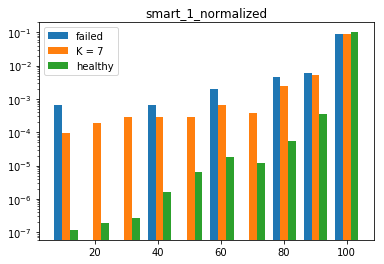

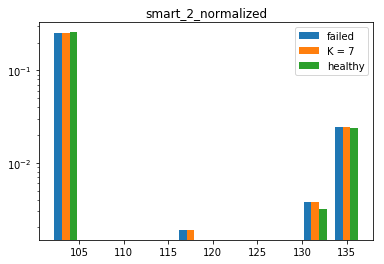

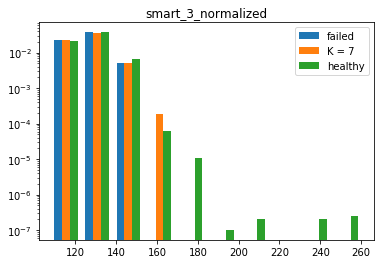

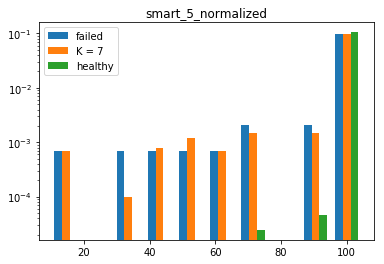

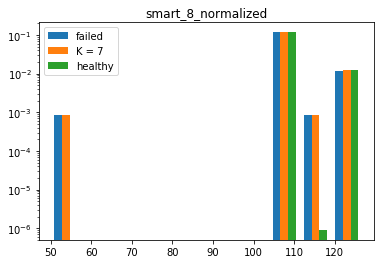

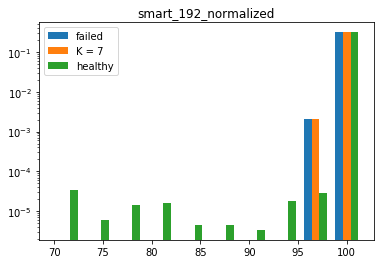

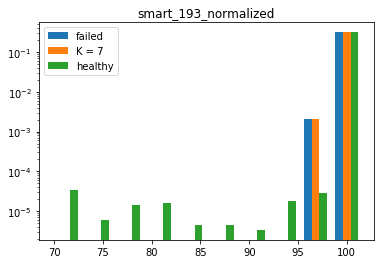

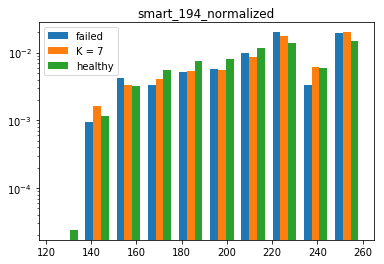

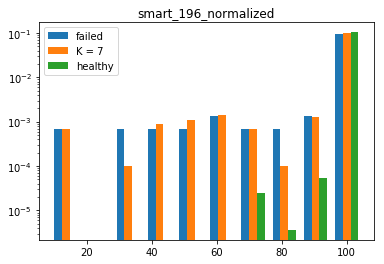

In [7]:
# We now apply CompareHistograms to every SMART metric and plot the comparing histogram

for smart_metric in smart_metrics :

    dfh1 = df_failure.loc[(slice(None),slice(None)), smart_metric].values
    dfh2 = df_failure_K.loc[(slice(None),slice(None)), smart_metric].values
    dfh3 = df_healthy.loc[(slice(None),slice(None)), smart_metric].values

    fig, ax = CompareHistograms(dfh1,dfh2,dfh3, hist_range = (df_smartmetrics_minmax.loc['min',smart_metric],df_smartmetrics_minmax.loc['max',smart_metric]) )
    plt.title(smart_metric)
    
    plt.yscale('log')
    plt.legend(['failed','K = %s' % K,'healthy'])
    
    plt.show()

